# 0. Install and Import Dependencies

In [1]:
#Installing the required librarries
%pip install mediapipe opencv-python pandas scikit-learn pyttsx3 matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import mediapipe as mp 
import cv2 # Import opencv
import pyttsx3 
import sys
sys.path.insert(0, r'C:\Users\kamar\OneDrive\Desktop\project\Silent-Face-Anti-Spoofing-master')
from mytest import test # Import function for spoof detection
engine = pyttsx3.init() # Initialize the text-to-speech engine


In [3]:
mp_drawing = mp.solutions.drawing_utils # Drawing helpers
mp_holistic = mp.solutions.holistic # Mediapipe Solutions

# 1. Make Some Detections

In [4]:
#Initiating webcam connection
cap = cv2.VideoCapture(0)
# Initiate holistic model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
      # specified detection and tracking confidence thresholds can be modified on preference
  
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Recolor Feed
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False        
        
        # Make Detections
        results = holistic.process(image)
        
        # Recolor image back to BGR for rendering
        image.flags.writeable = True   
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # 1. Draw face landmarks
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                                 mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                                 mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                                 )
        
        # 2. Draw Right hand landmarks
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                                 )

        # 3. Draw Left Hand landmarks
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                                 )

        # 4. Draw Pose landmarks
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                 )
                        
        cv2.imshow('Raw Webcam Feed', image) # Webcam display

        if cv2.waitKey(10) & 0xFF == ord('q'):# webcam closes upon pressing 'q'
            break

cap.release()
cv2.destroyAllWindows()

In [5]:
results.pose_landmarks.landmark[32].visibility # Checking visibility of one of the 33 pose landmarks
# Visibility can't be checked for face landmarks

0.0025128950364887714

# 2. Capture Landmarks & Export to CSV
<!--<img src="https://i.imgur.com/8bForKY.png">-->
<!--<img src="https://i.imgur.com/AzKNp7A.png">-->

In [6]:
import csv 
import numpy as np 

In [7]:
num_coords = len(results.pose_landmarks.landmark)+len(results.face_landmarks.landmark) # Total number of landmarks
num_coords

501

In [8]:
landmarks = ['class'] # class column initialized for the landmarker headers list
for val in range(1, num_coords+1): # Headers for landmarks and visibility score
    landmarks += ['x{}'.format(val), 'y{}'.format(val), 'z{}'.format(val), 'v{}'.format(val)]

In [10]:
with open('coords.csv', mode='w', newline='') as f:
    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(landmarks) # Write the headers created into the csv file
    # The mode = 'w' erases everything, only run once at beginning unless restarting the 
    # whole process or want to delete certain landmarks without deleting all videos 

In [13]:

import cv2 
import os
from datetime import datetime 
import mediapipe as mp

# Function to create directories if they don't exist
def create_folders(base_folder, folder_names):
    folder_paths = []
    for folder_name in folder_names:
        folder_path = os.path.join(base_folder, folder_name)
        os.makedirs(folder_path, exist_ok=True)
        folder_paths.append(folder_path)
    return folder_paths

# Function to collect landmarks
def collect_landmarks(results):
    try:
        # Extract Pose landmarks
        pose = results.pose_landmarks.landmark
        pose_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in pose]).flatten())
        
        # Extract Face landmarks
        face = results.face_landmarks.landmark
        face_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in face]).flatten())
        
        # Concatenate rows
        row = pose_row + face_row

        return row
    except:
        return []
    
 # Function to add the landmarks to the csv file   
def write_landmarks(video_path, folder_name, all_landmarks_data, output_csv):
    # For each set of landmarks in the recording session
        for landmarks in all_landmarks_data:
         if landmarks:
            try:
                # Create a row starting with the folder name and followed by the landmarks data
                row = [folder_name] + landmarks
                
                # Write to CSV
                with open(output_csv, mode='a', newline='') as f:
                    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                    csv_writer.writerow(row)
            except Exception as e:
                print(f"Error processing landmarks for {video_path}: {e}")


# Webcam and recording function
def record_videos_for_folders(folder_paths,output_csv,choice):
    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print("Error: Could not open video capture.")
        return []

    recording = False
    out = None
    folder_idx = 0  # To switch between folders
    
    landmarks_data = []  # Store landmarks data for each recording session

    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while cap.isOpened():
            ret, frame = cap.read()

            if not ret:
                print("Failed to grab frame")
                break

            
            folder_path = folder_paths[folder_idx] #current folder path
            folder_name = os.path.basename(folder_path) #getting folder name

            if choice == 'r':
               # Recolor feed
               image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
               image.flags.writeable = False

                # Process the image only if recording
               if recording:
                  results = holistic.process(image)
                  frame_landmarks = collect_landmarks(results)
                
                  if frame_landmarks:
                    landmarks_data.append(frame_landmarks)

                 # Recolor image back to BGR for rendering
                  image.flags.writeable = True
                  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

                 # Draw face landmarks
                  mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                                          mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                                          mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1))

                  # Draw pose landmarks
                  mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                          mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                          mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))
                
                  # Draw Right hand landmarks
                  mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                                 )

                  # Draw Left Hand landmarks
                  mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                                )
        

               else:
                # Only show the webcam feed when not recording
                 image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            if choice == 'r':
               item = image
            elif choice == 't':
               item = frame

            if not recording:  
            # Display the current folder name on the frame
               cv2.putText(item, f'Folder: {folder_name}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
               cv2.putText(item, 'Press "s" to start, "e" to stop, "n" to switch folder, "q" to quit', (10, 60), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
            if recording:
             cv2.putText(item, "R...", (500, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)


            cv2.imshow('Webcam Feed', item) # display current frame in 'Webcam Feed' window

            key = cv2.waitKey(1) & 0xFF

            if key == ord('s') and not recording:
                print("Recording started...")
                timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
                video_file_name = f"video_{folder_name}_{timestamp}.avi"
                video_file_path = os.path.join(folder_path, video_file_name)
                fourcc = cv2.VideoWriter_fourcc(*'XVID') #Define the codec for video writing
                out = cv2.VideoWriter(video_file_path, fourcc, 20.0, (640, 480)) # Create a VideoWriter object
                recording = True

            elif key == ord('e') and recording:
                print(f"Recording stopped for {video_file_name}")
                recording = False
                if choice == 'r':
                   write_landmarks(folder_path, folder_name, landmarks_data, output_csv)
                   landmarks_data = [] # Clearing landmarks for next video
                if out:
                    out.release()

            elif key == ord('n') and not recording:
                folder_idx = (folder_idx + 1) % len(folder_paths)
                print(f"Switched to folder: {folder_paths[folder_idx]}")

            elif key == ord('q'):
                if recording:
                    print(f"Recording stopped for {video_file_name}")
                    if out:
                        out.release()
                break # loop escapes when 'q' is escaped

            if recording and out:
                out.write(frame)

    cap.release()
    if out:
        out.release()
    cv2.destroyAllWindows()

# Main function
def main():
    base_video_folder = r'C:\Users\kamar\OneDrive\Desktop\project\train' 
    test_video_folder = r'C:\Users\kamar\OneDrive\Desktop\project\test'
    # Base folders where training and testing folders are stored
    output_csv = r'coords.csv'

    choice=input("Enter 'r' for training videos or 't' for testing videos or 'p' for processing videos:")

    # Start recording videos and processing landmarks
    if choice == 'r':
       folder_names = input("Enter folder names for the videos, separated by commas (e.g., 'jumping, walking, running'): ").split(',')
       folder_paths = create_folders(base_video_folder, folder_names)
       record_videos_for_folders(folder_paths,output_csv,choice)
    if choice == 't':   
        folder_names = [f for f in os.listdir(base_video_folder) if os.path.isdir(os.path.join(base_video_folder, f))]
        # folder_names taken from input given during 'r' is chosen
        # Modify if extra folders are needed

        folder_t_paths=create_folders(test_video_folder, folder_names)
        record_videos_for_folders(folder_t_paths,output_csv,choice)

    if choice == 'p':  

        # only processes the training folders and writes landmarks 
        # choose when coords.csv is erased or remove landmarks of a video
        folder_names = [f for f in os.listdir(base_video_folder) if os.path.isdir(os.path.join(base_video_folder, f))]

        for item in folder_names:
            folder_path = os.path.join(base_video_folder, item)

    # Iterate over videos in the folder
            for filename in os.listdir(folder_path):
                if filename.endswith('.mp4') or filename.endswith('.avi') or filename.endswith('.mov'):
            # Read video
                 video_path = os.path.join(folder_path, filename)

                 landmarks_data = []

            # Initiate holistic model
                 with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
                      cap = cv2.VideoCapture(video_path)
                
                      while cap.isOpened():
                            ret, frame = cap.read()
                            if not ret:
                               break

                            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                            image.flags.writeable = False

                            results = holistic.process(image)
                            frame_landmarks = collect_landmarks(results)
                
                            if frame_landmarks:
                               landmarks_data.append(frame_landmarks)

                            image.flags.writeable = True
                            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                            
                            folder_name = os.path.basename(folder_path)
                      write_landmarks(folder_path, folder_name, landmarks_data, output_csv)
                      
  
                cap.release()


if __name__ == "__main__":
    main()


# 3. Train Custom Model Using Scikit Learn

## 3.1 Read in Collected Data and Process

In [10]:
import pandas as pd # for data manipulation and analysis
from sklearn.model_selection import train_test_split

In [11]:
df = pd.read_csv('coords.csv') # data from csv to panda dataframe

In [12]:
df.head() # diaplay first 5 rows

,class,x1,y1,z1,v1,x2,y2,z2,v2,x3,...,z499,v499,x500,y500,z500,v500,x501,y501,z501,v501
0,air,0.533468,0.482521,-1.416471,0.998531,0.565029,0.405861,-1.301979,0.997953,0.582744,...,0.003778,0.0,0.613230,0.411553,0.031121,0.0,0.619443,0.403798,0.032415,0.0
1,air,0.533282,0.483682,-1.193921,0.998662,0.565006,0.405846,-1.095219,0.998139,0.582786,...,0.002424,0.0,0.611538,0.406767,0.029328,0.0,0.617634,0.399049,0.030567,0.0
2,air,0.533272,0.483861,-1.192895,0.998777,0.565024,0.405343,-1.096529,0.998303,0.582916,...,0.003743,0.0,0.612903,0.409443,0.030903,0.0,0.619214,0.401879,0.032183,0.0
3,air,0.532663,0.485036,-1.187855,0.998870,0.564938,0.405376,-1.091852,0.998435,0.582922,...,0.003299,0.0,0.612807,0.408601,0.029448,0.0,0.619097,0.400877,0.030680,0.0
4,air,0.532095,0.485732,-1.232786,0.998954,0.564888,0.405338,-1.132970,0.998556,0.582940,...,0.003318,0.0,0.612898,0.408754,0.029922,0.0,0.619252,0.400849,0.031202,0.0


In [13]:
df.tail() # diaplay last 5 rows

,class,x1,y1,z1,v1,x2,y2,z2,v2,x3,...,z499,v499,x500,y500,z500,v500,x501,y501,z501,v501
147,video,0.530644,0.475659,-1.507911,0.999964,0.567291,0.394479,-1.403400,0.999940,0.586634,...,0.001996,0.0,0.618322,0.395206,0.025760,0.0,0.625034,0.387682,0.026676,0.0
148,video,0.531025,0.475676,-1.512728,0.999963,0.567799,0.394511,-1.408575,0.999938,0.586980,...,0.002033,0.0,0.617334,0.396005,0.025833,0.0,0.624036,0.388090,0.026852,0.0
149,video,0.531438,0.475634,-1.519982,0.999962,0.568232,0.394512,-1.416147,0.999936,0.587307,...,0.001870,0.0,0.617555,0.395928,0.025420,0.0,0.624187,0.388250,0.026377,0.0
150,video,0.531477,0.475645,-1.523770,0.999962,0.568349,0.394532,-1.420519,0.999935,0.587417,...,0.001687,0.0,0.617703,0.395599,0.025566,0.0,0.624416,0.388144,0.026502,0.0
151,video,0.531507,0.475402,-1.550877,0.999961,0.568396,0.394494,-1.447158,0.999934,0.587475,...,0.001827,0.0,0.617654,0.395430,0.025794,0.0,0.624415,0.387917,0.026715,0.0


In [15]:
# Split data into features (X) and target (y)
X = df.drop('class', axis=1) # features
y = df['class'] # target value
# Define the folders for training and testing #Whenthe data is manually split data into test and train sets
#training_folders = ['folder1', 'folder2']  # Replace with your actual training folder names
#testing_folders = ['folder3', 'folder4']    # Replace with your actual testing folder names

# Filter the DataFrame based on the selected folders
train_data = df[df['class'].isin(training_folders)]
test_data = df[df['class'].isin(testing_folders)]

In [16]:
# Split data into training and testing sets; 30% of data is used for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)
#when the train and test data is manually split
#X_train = train_data.drop('class', axis=1)  # features
#y_train = train_data['class']  # target value
#X_test = test_data.drop('class', axis=1)  # features
#y_test = test_data['class']  # target value

## 3.2 Train Machine Learning Classification Model

In [18]:
# Import libraries for building machine learning pipelines and scaling features
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler 

# Import classifiers for the pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [19]:
# Define machine learning pipelines with standard scaling and different classifiers
pipelines = {
    'lr':make_pipeline(StandardScaler(), LogisticRegression()),
    'rc':make_pipeline(StandardScaler(), RidgeClassifier()),
    'rf':make_pipeline(StandardScaler(), RandomForestClassifier()),
    'gb':make_pipeline(StandardScaler(), GradientBoostingClassifier()),
}

In [20]:
fit_models = {}
for algo, pipeline in pipelines.items():
    model = pipeline.fit(X_train, y_train)  # Train the model on the training set with different algorithms
    fit_models[algo] = model 

In [21]:
fit_models

{'lr': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression', LogisticRegression())]),
 'rc': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('ridgeclassifier', RidgeClassifier())]),
 'rf': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier', RandomForestClassifier())]),
 'gb': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('gradientboostingclassifier', GradientBoostingClassifier())])}

## 3.3 Evaluate and Serialize Model 

In [23]:
from sklearn.metrics import accuracy_score, f1_score
import pickle 

In [24]:
fit_models = {}
accuracy_scores = {}
f1_scores = {}

#Calculate metrics
for algo, pipeline in pipelines.items():
    y_pred = model.predict(X_test)
    accuracy_scores[algo] = accuracy_score(y_test, y_pred)
    f1_scores[algo] = f1_score(y_test, y_pred, average='weighted')  # Weighted average handles multi-class

# Find the model with the highest accuracy first
highest_accuracy = max(accuracy_scores.values())
best_models = [algo for algo, score in accuracy_scores.items() if score == highest_accuracy]

# If multiple models have the highest accuracy, use F1-score to break ties
if len(best_models) > 1:
    best_model_key = max(best_models, key=lambda x: f1_scores[x])
else:
    best_model_key = best_models[0]

best_model = fit_models[best_model_key]

print(f"Best model: {best_model_key} with accuracy: {accuracy_scores[best_model_key]:.4f} and F1-score: {f1_scores[best_model_key]:.4f}")


lr 1.0
rc 1.0
rf 1.0
gb 1.0


In [30]:
# Save the best model
with open('body_language.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# 4. Make Detections with Model

In [31]:
with open('body_language.pkl', 'rb') as f: # Load the pre trained model
    model = pickle.load(f)

In [32]:
model # Display the specifications of chosen model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier', RandomForestClassifier())])

In [1]:
# Function to split the class name into two lines if it's too long
def split_text(text, max_length=8):
    words = text.split()
    if len(text) <= max_length:
        return text, ""
    
    # Attempt to split roughly in the middle
    mid_index = len(words) // 2
    line1 = " ".join(words[:mid_index])
    line2 = " ".join(words[mid_index:])
    
    return line1, line2

cap = cv2.VideoCapture(0)

prev_body_language_class=""
prev_spoof_state = False

# Initiate holistic model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    process_every_n_frames = 5 # Process every nth frame to reduce workload
    frame_counter = 0

    while cap.isOpened():

        ret, frame = cap.read()
        if not ret:
            break

        frame_counter += 1
        if frame_counter % process_every_n_frames != 0:
            continue

        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False  

         # Call custom function `test` for anti-spoofing detection
        tup = test(image=image,model_dir="Silent-Face-Anti-Spoofing-master\\resources\\anti_spoof_models", device_id=0)
        
        results = holistic.process(image)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        image.flags.writeable = True 

        # Proceed only if anti-spoofing is successful and confidence is high enough
        if(tup[0]==1 and tup[1]>0.05):  
            prev_spoof_state = False  
            
            # 1. Draw face landmarks
            mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                                    mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                                    mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                                    )
            
            # 2. Right hand
            mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                    mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                                    mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                                    )

            # 3. Left Hand
            mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                    mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                                    mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                                    )

            # 4. Pose Detections
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, 
                                    mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                    mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                    )
            
            try:
                # Extract Pose landmarks
                pose = results.pose_landmarks.landmark
                pose_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in pose]).flatten())
                
                # Extract Face landmarks
                face = results.face_landmarks.landmark
                face_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in face]).flatten())
                
                # Concate rows
                row = pose_row+face_row
                
                X = pd.DataFrame([row])

                # Predicting class and probability
                body_language_class = model.predict(X)[0]
                body_language_prob = model.predict_proba(X)[0]
                print(body_language_class, body_language_prob)
                line1, line2 = split_text(body_language_class)

                  # Resize the image to fit the webcam resolution (640x480)
                image_resized = cv2.resize(image, (640, 480))

                # Get the dimensions of the image for placing text at the bottom left
                height, width, _ = image_resized.shape
                
                # Adjust the height of the blue box to accommodate two lines if necessary
                box_height = 60 if not line2 else 80
                # Add a blue box at the bottom left
                cv2.rectangle(image_resized, (0, height - box_height), (250, height), (255, 0, 0), -1)  # Blue box (BGR: 255, 0, 0)
                # Add text for Class at bottom left
                cv2.putText(image_resized, 'CLASS', (10, height - box_height + 20), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                cv2.putText(image_resized, line1, (10, height - box_height + 45), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
        
                # If there is a second line, add it just below the first one
                if line2:
                   cv2.putText(image_resized, line2, (10, height - box_height + 70), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
                
                # If the predicted class has changed, use text-to-speech to announce it
                if prev_body_language_class!=body_language_class:
                    engine.say(body_language_class)
                    engine.runAndWait()
                    engine.stop()
                    prev_body_language_class=body_language_class

                # Add text for Probability at bottom left
                if line2:
                   cv2.putText(image_resized, 'PROB', (175,height - box_height + 20), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                   prob_text = str(round(body_language_prob[np.argmax(body_language_prob)], 2))
                   cv2.putText(image_resized, prob_text, (175, height - box_height + 57), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)

                else:
                   cv2.putText(image_resized, 'PROB', (130,height - box_height + 20), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                   prob_text = str(round(body_language_prob[np.argmax(body_language_prob)], 2))
                   cv2.putText(image_resized, prob_text, (130, height - box_height + 45), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)    
                
            except:
                pass
        else:
            
            # If spoofing detected or confidence is too low, display 'spoof' message
            box_height = 60 if not line2 else 80
            cv2.rectangle(image_resized, (10, height - box_height), (250, height), (255, 0, 0), -1)  # Blue box (BGR: 255, 0, 0)
            cv2.putText(image_resized, "spoof", (10, height - box_height + 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(image_resized, 'PROB', (130,height - box_height + 20), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            prob_text = str(round(tup[1], 2)) if tup is not None else 'N/A'
            cv2.putText(image_resized, prob_text, (130, height - box_height + 50), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)

            if not prev_spoof_state:
                            engine.say("SPOOF")
                            engine.runAndWait()
                            engine.stop()
                            prev_spoof_state = True            
        cv2.imshow('Raw Webcam Feed', image_resized)

        if cv2.waitKey(10) & 0xFF == ord('q'):

            
            break

cap.release()
cv2.destroyAllWindows()

NameError: name 'cv2' is not defined

In [42]:
tuple(np.multiply(np.array((results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_EAR].x, 
results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_EAR].y)), [640,480]).astype(int))

(np.int64(409), np.int64(219))

In [33]:
#Initializing placeholders for true labels and predictions
_true=[]
pred=[]
true_spoof = []
pred_spoof = []

In [35]:
import os
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd

# Define the path to the folder where you want to save the processed videos
output_video_dir = r'C:\Users\kamar\OneDrive\Desktop\project\processed_videos'
os.makedirs(output_video_dir, exist_ok=True)  # Create the folder if it doesn't exist

#  Dynamically get folder names from the given path
base_output_dir = r'C:\Users\kamar\OneDrive\Desktop\project\test'  # Path to the main folder containing subfolders
folder_names = [f for f in os.listdir(base_output_dir) if os.path.isdir(os.path.join(base_output_dir, f))]

# Process the videos in the folders
for item in folder_names:
    folder_path = os.path.join(base_output_dir, item)

    # Iterate over videos in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.mp4') or filename.endswith('.avi') or filename.endswith('.mov'):
            # Read video
            video_path = os.path.join(folder_path, filename)
            output_video_path = os.path.join(output_video_dir, f"processed_{filename}")  # Save path for the output video

            prev_body_language_class = ""
            prev_spoof_state = False  # Track if "SPOOF" has already been announced


            # Initiate holistic model
            with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
                cap = cv2.VideoCapture(video_path)

                # Get video properties for saving
                width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                fps = cap.get(cv2.CAP_PROP_FPS)
                
                # Define the codec and create VideoWriter object for saving the output video
                fourcc = cv2.VideoWriter_fourcc(*'XVID')
                out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
                
                while cap.isOpened():
                    ret, frame = cap.read()
                    if not ret:
                        break

                    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    image.flags.writeable = False

                    #Detection for spoof
                    tup = test(image, model_dir="Silent-Face-Anti-Spoofing-master\\resources\\anti_spoof_models", device_id=0)
                    
                     # Append true and predicted labels for spoof detection
                    true_spoof.append(1 if "real" in filename.lower() else 0)  # Assuming filenames indicate real/spoof
                    pred_spoof.append(tup[0])  # 1 for real, 0 for spoof
                    
                    # Process image and extract landmarks
                    results = holistic.process(image)
                    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                    image.flags.writeable = True

                    if (tup[0]==1 and tup[1]>0.05):   # If real input is detected with high confidence
                        # Reset spoof announcement tracking when real input is detected
                        prev_spoof_state = False

                    # Draw landmarks
                        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                                              mp_drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1),
                                              mp_drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1))

                        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                              mp_drawing.DrawingSpec(color=(80, 22, 10), thickness=2, circle_radius=4),
                                              mp_drawing.DrawingSpec(color=(80, 44, 121), thickness=2, circle_radius=2))

                        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                              mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
                                              mp_drawing.DrawingSpec(color=(121, 44, 250), thickness=2, circle_radius=2))

                        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                              mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=4),
                                              mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))

                    # Try to process the landmarks
                        try:
                        # Extract Pose landmarks
                            pose = results.pose_landmarks.landmark
                            pose_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in pose]).flatten())
                        
                           # Extract Face landmarks
                            face = results.face_landmarks.landmark
                            face_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in face]).flatten())
                        
                           # Concatenate the pose and face rows
                            row = pose_row + face_row
                            X = pd.DataFrame([row])

                           # Make predictions using chosen model
                            body_language_class = model.predict(X)[0]
                            body_language_prob = model.predict_proba(X)[0]
                            print(body_language_class, body_language_prob)

                           # Append for evaluation
                            _true.append(item)
                            pred.append(body_language_class)
                      
                           # Draw a status box on the image.
                            cv2.rectangle(image, (0,0), (250, 60), (245, 117, 16), -1)


                           # Add the predicted class to display on the video feed
                            cv2.putText(image, 'CLASS'
                                        , (95,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                            cv2.putText(image, body_language_class.split(' ')[0]
                                        , (90,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                            
                             # If the predicted class changes, announce it via text-to-speech (TTS)
                            if prev_body_language_class != body_language_class:
                               engine.say(body_language_class)
                               engine.runAndWait()
                               engine.stop()
                               prev_body_language_class = body_language_class


                           # Add the predicted probability to display on the video feed
                            cv2.putText(image, 'PROB'
                                        , (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                            cv2.putText(image, str(round(body_language_prob[np.argmax(body_language_prob)],2))
                                        , (10,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                    
                        except:
                            print("Error processing landmarks or making predictions.")
                            pass
                    else:    
                # If spoof is detected, display 'SPOOF' and its probability
                       cv2.rectangle(image, (0,0), (250, 60), (245, 117, 16), -1)
                       cv2.putText(image, "spoof"
                            , (90,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                       cv2.putText(image, 'PROB'
                            , (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                       cv2.putText(image, str(round(tup[1],2)), (10,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

                       # Announce "SPOOF" via text-to-speech only once per spoof detection
                       if not prev_spoof_state:
                            engine.say("SPOOF")
                            engine.runAndWait()
                            engine.stop()
                            prev_spoof_state = True

                    # Write the frame to the output video file
                    out.write(image)   
                 
                    # Display the video feed with landmarks and predicted info
                    cv2.imshow('Processed Video Feed', image)

                    if cv2.waitKey(10) & 0xFF == ord('q'):
                        break

                cap.release()
                out.release()

cv2.destroyAllWindows()


hello [0.46 0.54 0.  ]
hello [0.45 0.55 0.  ]
hello [0.45 0.55 0.  ]
hello [0.44 0.56 0.  ]
hello [0.44 0.56 0.  ]
hello [0.44 0.56 0.  ]
hello [0.43 0.57 0.  ]
hello [0.43 0.57 0.  ]
hello [0.43 0.57 0.  ]
hello [0.44 0.56 0.  ]
hello [0.14 0.82 0.04]
hello [0.16 0.79 0.05]
hello [0.11 0.84 0.05]
hello [0.05 0.9  0.05]
hello [0.09 0.88 0.03]
hello [0.16 0.81 0.03]
hello [0.04 0.9  0.06]
hello [0.01 0.68 0.31]
hello [0.2  0.75 0.05]
hello [0.07 0.85 0.08]
hello [0.21 0.73 0.06]
hello [0.27 0.68 0.05]
hello [0.22 0.73 0.05]
hello [0.23 0.71 0.06]
hello [0.17 0.77 0.06]
hello [0.12 0.82 0.06]
hello [0.11 0.83 0.06]
hello [0.14 0.84 0.02]
hello [0.27 0.68 0.05]
hello [0.34 0.66 0.  ]
hello [0.35 0.62 0.03]
hello [0.34 0.6  0.06]


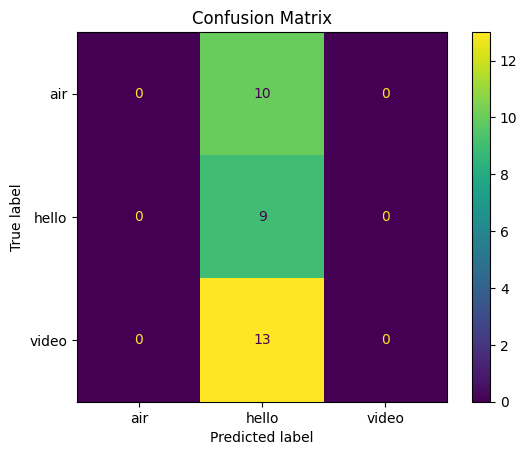

Accuracy: 0.28
Class: air
 Precision: 0.00
 Recall: 0.00
 F1 Score: 0.00

Class: hello
 Precision: 0.28
 Recall: 1.00
 F1 Score: 0.44

Class: video
 Precision: 0.00
 Recall: 0.00
 F1 Score: 0.00

Macro Precision: 0.09
Macro Recall: 0.33
Macro F1 Score: 0.15


In [36]:
#metrics for classification
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd

# Define the folder where you want to save the images
output_folder = r'C:\Users\kamar\OneDrive\Desktop\project\metrics'  # Change this to your desired folder path
os.makedirs(output_folder, exist_ok=True)  # Create the folder if it doesn't exist

result=metrics.confusion_matrix(_true,pred,labels=folder_names)

# Normalize the confusion matrix (row-wise normalization)
result_normalized = result.astype('float') / result.sum(axis=1)[:, np.newaxis]
accuracy = metrics.accuracy_score(_true, pred)

# Display the confusion matrix
_display=metrics.ConfusionMatrixDisplay(confusion_matrix=result_normalized,display_labels=folder_names)
_display.plot()
plt.title(f'Confusion Matrix')
plt.show()

# Calculate precision, recall, and F1 score for each class
precision = metrics.precision_score(_true, pred, labels=folder_names, average=None)
recall = metrics.recall_score(_true, pred, labels=folder_names, average=None)
f1_score = metrics.f1_score(_true, pred, labels=folder_names, average=None)

# Create a DataFrame for precision, recall, and F1 score for each class
metrics_df = pd.DataFrame({
    'Class': folder_names,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1_score
})

# Calculate macro-averaged precision, recall, and F1 score
macro_metrics = {
    'Macro Precision': [round(metrics.precision_score(_true, pred, average='macro'), 2)],
    'Macro Recall': [round(metrics.recall_score(_true, pred, average='macro'), 2)],
    'Macro F1 Score': [round(metrics.f1_score(_true, pred, average='macro'), 2)]
}

# Create a DataFrame for macro-averaged metrics
macro_df = pd.DataFrame(macro_metrics)

# Function to render a table as an image
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     output_file='table_image.png'):
    fig, ax = plt.subplots(figsize=(np.array(data.shape[::-1]) * np.array([col_width, row_height])))
    ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0] % len(row_colors)])

    fig.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.close(fig)

# Render the per-class metrics table and save it as an image


# Render the macro-averaged metrics table and save it as an image
render_mpl_table(macro_df, header_columns=0, col_width=4.0, output_file='macro_metrics.png')

# Render the metrics table and save the images
metrics_table_path = os.path.join(output_folder,'classification_metrics.png')
render_mpl_table(metrics_df, header_columns=0, col_width=4.0, output_file=metrics_table_path)

metrics_table_path = os.path.join(output_folder,'macro_metrics.png')
render_mpl_table(metrics_df, header_columns=0, col_width=4.0, output_file=metrics_table_path)

print("Tables saved as 'classification_metrics.png' and 'macro_metrics.png'")


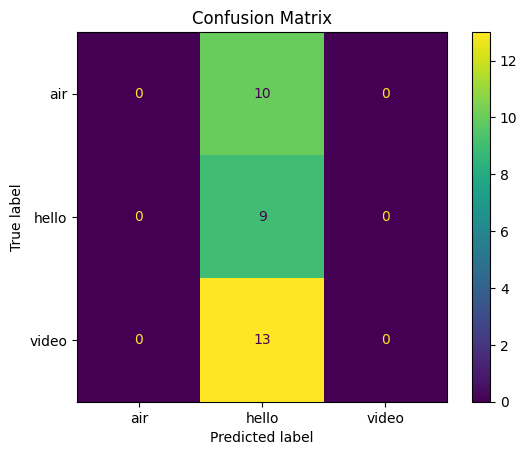

Accuracy: 0.28
Class: air
 Precision: 0.00
 Recall: 0.00
 F1 Score: 0.00

Class: hello
 Precision: 0.28
 Recall: 1.00
 F1 Score: 0.44

Class: video
 Precision: 0.00
 Recall: 0.00
 F1 Score: 0.00

Macro Precision: 0.09
Macro Recall: 0.33
Macro F1 Score: 0.15


In [ ]:
#metrics for liveliness detection
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

# Define the folder where you want to save the images
output_folder = r'C:\Users\kamar\OneDrive\Desktop\project\metrics'  # Change this to your desired folder path
os.makedirs(output_folder, exist_ok=True)  # Create the folder if it doesn't exist

result=confusion_matrix(true_spoof, pred_spoof, labels=[0, 1])

# Normalize the confusion matrix (row-wise normalization)
result_normalized = result.astype('float') / result.sum(axis=1)[:, np.newaxis]

# Display confusion matrix for spoof detection
display_spoof = metrics.ConfusionMatrixDisplay(confusion_matrix=result_normalized, display_labels=['Spoof', 'Real'])
display_spoof.plot()
plt.show()

# Calculate accuracy, precision, recall, and f1-score
accuracy =np.round(metrics.accuracy_score(true_spoof, pred_spoof),2)
precision = np.round(metrics.precision_score(true_spoof, pred_spoof, average='binary'),2)
recall = np.round(metrics.recall_score(true_spoof, pred_spoof, average='binary'),2)
f1 = np.round(metrics.f1_score(true_spoof, pred_spoof, average='binary'),2)

# Create a DataFrame with the calculated metrics
metrics_data = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Score': [accuracy, precision, recall, f1]
})

# Define the function to render the table as an image
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0, output_file='table_image.png'):
    fig, ax = plt.subplots(figsize=(np.array(data.shape[::-1]) * np.array([col_width, row_height])))
    ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0] % len(row_colors)])

    fig.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.close(fig)


# Render the metrics table and save as an image
metrics_table_path = os.path.join(output_folder, 'metrics_table.png')
render_mpl_table(metrics_data, output_file=metrics_table_path)


print("Table saved as 'metrics_table'")